---
layout: default
title: "Deep Learning - RNN - Sequence models"
categories: deeplearning
permalink: /ML43/
order: 43
comments: true
---

In [1]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"
from matplotlib.patches import Rectangle, Circle
from mpl_flow import Flow

Populating the interactive namespace from numpy and matplotlib


# Sequence Models 
Models like Recurrent Neural Networks (RNNs) have transformed many fields, as for example speech recognition and natural language processing. There are a lot of different types of sequence problems that can be treated as supervised learning problems:

* In speech recognition an input audio source $x$ is mapped to an output text $y$. Both the input and the output are sequence data, because $x$ plays over time and $y$ is a sequence of words.
* In music generation the output $y$ is a sequence, while the input can be void or it may be a single number encoding for the genre or style of music to generated. 
* In sentiment classification the input $x$ is one or more sentences (sequence) while the output $y$ is a number encoding for the quality of the object to which the input refers. 
* Sequence models are also widely used in DNA sequence analysis.
* In machine translation the input $x$ is a sentence that is translated in another output sentence $y$
* In video activity recognition an activity $y$ is recognized from a sequence of video frames $x$
* In name entity recognition entities $y$ like for example peoples are detected in an input sentence $x$

## Notation
Suppose you want a sequence model that extract character names from a sentence $x$ and classifies each word as character name (1) or not (0). This is an example of **Natural Language Processing**.

In [2]:
sentence = "Rand is a friend of Perrin and they both live in the twin rivers"
vector = "1    0  0 0      0  1      0   0    0    0    0  0   0    0"

print("x:\t{}\ny:\t{}".format(sentence, vector))

x:	Rand is a friend of Perrin and they both live in the twin rivers
y:	1    0  0 0      0  1      0   0    0    0    0  0   0    0


The input is a sequence of 13 words ($T_x=13$). They are represented by a set of 13 features to which we will refer as $x^{\langle 1 \rangle}, \dots ,x^{\langle 13 \rangle}$ or more in general they will be referred to as $x^{\langle t \rangle}$ where $t$ implies that they are temporal sequences regardless whether the sequence is temporal or not.

Similarly we refer to $y^{\langle 1 \rangle}, \dots , y^{\langle t \rangle} , \dots,y^{\langle 13 \rangle}$ which has length $T_y$. In this example $T_x = T_y = 13$ but they can be different.

Each training example $X^{(i)}$ has a label associated to some features $t$. To refer to feature $t$ of training example $i$ we use $X^{(i)\langle t \rangle}$. Each training example might have a different number of input features $T_x$. To refer to the number of input features of training example $i$ we use $T_x^{(i)}$. Similarly $y^{(i)\langle t \rangle}$ refers to the $t$-th element in the output sequence of the $i$-th training example and $T_y^{(i)}$ refers to the length of the output sequence in the $i$-the training example.

The representation of individual words $x^{\langle 1 \rangle}$ is based on a vocabulary (or dictionary) $V$, a set of all the words that can be used in a representation. Once a dictionary is defined, one way to represent a word, called **one-hot** representation, is with a vector of the same size of the dictionary where the only non-zero value is at the index of the word in the vocabulary.

$$
V = 
\begin{bmatrix}
\text{a} \\ \vdots \\ \text{is} \\ \vdots \\ \text{Rand} \\ \vdots \\ \text{zulu}
\end{bmatrix}
\begin{matrix}
1 \\ \vdots \\ 2100 \\ \vdots \\8000 \\ \vdots \\ 10.000
\end{matrix}
\qquad x^{\langle 1 \rangle}=
\begin{bmatrix}
0 \\ \vdots \\ 0 \\ \vdots \\ 1 \\ \vdots \\ 0
\end{bmatrix}
\qquad x^{\langle 2 \rangle}=
\begin{bmatrix}
0 \\ \vdots \\ 1 \\ \vdots \\ 0 \\ \vdots \\ 0
\end{bmatrix}
$$

In this representation $x^{\langle t \rangle}$ is a one-hot vector and the task is given this representation for $x$ to learn a mapping to the target output $y$. This is faced as a supervised learning problem trained on labeled data $(x,y)$.

## Recurrent Neural Network Model
The task defined above is to produce a mapping $x \to y$, where $x$ is a series of $T_x$ one-shot vectors and $y$ is a series of $T_y$ output values. With a regular neural network we would incur in a number of problems:

* Input and outputs can be of different lengths in different examples, while we could 0-pad to a fixed length all inputs this is not a good representation
* A regular neural network doesn't share features learned across different position of text. If a model learns that a word appearing in position 1 is a person's name, it is desirable for the model to learn that the same word at another position is equally a person's name. This is similar to what happens in CNNs, where features learned in one part of the image are generalized to other parts of the image.
* A weight matrix for an input layer of the dimensions of the vocabulary (tens or hundreds of thousands of elements) would imply an enormous amount of parameters.

A RNN has none of these problems: When modelling this data in a recurrent neural network we would take the first word of a sentence $x^{\langle 1 \rangle}$ and feed it into a layer of the RNN. This layer would predict if the first word is a person's name or not, producing the output $y^{\langle 1 \rangle}$. In the second step, the second word $x^{\langle 2 \rangle}$ is passed to the layer together with the activation of the previous step $a^{\langle 1 \rangle}$, to produce $y^{\langle 2 \rangle}$. At each time-step the RNN feeds the input $x^{\langle t \rangle}$ and the activation of the previous time-step $a^{\langle t-1 \rangle}$ to produce a prediction $y^{\langle t \rangle}$. The first layer is usually fed a vector of zeros or random values $a^{\langle 0 \rangle}$.

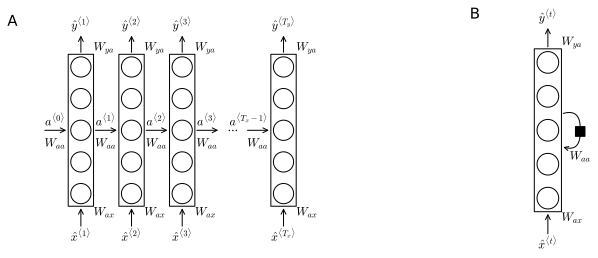

In [3]:
fig, axes = plt.subplots(1,2, figsize=(12 , 4))
ax1, ax2 = axes

def layer(ax, idx, units):
    height = units+1
    r = Rectangle((idx*2, 1), 1, height, fc='none', ec='k')
    for y in  np.linspace(1, height, units):
        ax.add_artist(Circle((idx*2+.5, y+.5), .4, fc='none', ec='k'))
    ax.add_artist(r)
    return r

def io(l, input_lbl, output_lbl, fontsize):
    plt.annotate('$\\hat{{x}}^{{\\langle {} \\rangle}}$'.format(input_lbl), (0.5, 0), (0.5, -0.2), xycoords=l, textcoords=l, 
             arrowprops=dict(arrowstyle='->'), va='center', ha='center', fontsize=fontsize)
    plt.annotate('$\\hat{{y}}^{{\\langle {} \\rangle}}$'.format(output_lbl), (0.5, 1), (0.5, 1.2), xycoords=l, textcoords=l, 
             arrowprops=dict(arrowstyle='<-'), va='center', ha='center', fontsize=fontsize)

def params(l, fontsize):
    plt.annotate('$W_{{ax}}$', (0, 0), (1, 0), textcoords=l, 
                 va='top', ha='left', fontsize=fontsize)
    plt.annotate('$W_{{ya}}$', (0, 0), (1, 1), textcoords=l, 
                 va='bottom', ha='left', fontsize=fontsize)


def rnn(style, layers, units, shadow_layer=False, fontsize=12, ax=None):

    
    if style=='extended':
        rnn_extended(layers, units, shadow_layer=shadow_layer, fontsize=fontsize, ax=ax)
    elif style=='loopy':
        layers=1
        rnn_loopy(units, fontsize, ax=ax)
    else:
        pass
        
    ax.set_xlim(0, (layers+1)*2)
    ax.set_ylim(0, units+3)
    ax.set_aspect('equal')
    ax.set_axis_off()

def rnn_loopy(units, fontsize, ax=None):
    l = layer(ax, 1, units)
    io(l, 't', 't', fontsize)
    
    a = plt.annotate('', (1, 0.4), (1, 0.6), xycoords=l, textcoords=l, va='center', ha='center', 
                 arrowprops=dict(arrowstyle='->',connectionstyle='arc,angleA=20,angleB=160,armA=20,armB=-20,rad=21'))
    plt.annotate('   ', (0, 0), (1, 0.5), textcoords=a.arrow_patch, 
                 bbox=dict(boxstyle='square', fc='k', pad=0), va='center', ha='center')
    plt.annotate('$W_{{aa}}$', (0, 0), (1, 0), textcoords=a.arrow_patch, 
     va='top', ha='center', fontsize=fontsize)
    params(l, fontsize)
    
def rnn_extended(layers, units, shadow_layer=False, fontsize=12, ax=None):


    for i in range(1, layers+1):
        xcoords = (-1, 0)
        prev_act = i-1 
        input_lbl = i 
        output_lbl = i
        
        if shadow_layer is True:
            if i == layers-1:
                xcoords= (1, 2)
                ax.text(layers*2-1.5, (units+3)/2, '$\\cdots$', ha='center', va='center', fontsize=fontsize)
            if i == layers:
                prev_act = 'T_x-1'
                input_lbl = 'T_x'
                output_lbl = 'T_y'
        if shadow_layer is False or i != layers - 1:
            l = layer(ax, i, units)       
            io(l, input_lbl, output_lbl, fontsize)
            params(l, fontsize)
            

            
        a = plt.annotate('', (xcoords[0], 0.5), (xcoords[1], 0.5), xycoords=l, textcoords=l, 
         arrowprops=dict(arrowstyle='<-'), va='center', ha='center', fontsize=fontsize)
        plt.annotate('$a^{{\\langle {} \\rangle}}$'.format(prev_act), (0, 0), (1, 1), textcoords=a.arrow_patch, 
             va='bottom', ha='right', fontsize=fontsize)
        plt.annotate('$W_{{aa}}$', (0, 0), (0.5, -1), textcoords=a.arrow_patch, 
             va='top', ha='center', fontsize=fontsize)
        

rnn('extended', 5, 5, shadow_layer=True, ax=ax1)
rnn('loopy', 1, 5, ax=ax2)
for ax, l in zip(axes, 'AB'):
    ax.text(0, 1, l, va='bottom', ha='right', fontsize=15, transform=ax.transAxes)

<i id="fig:rnn">Two equivalent representations of a recurrent neural network (RNN) model. In the left panel (A), each box represents a time step. One element in the input sequence $x^{\langle t \rangle}$ is fed to an hidden layer, which takes as an additional input the activations of the previous step $a^{\langle t-1 \rangle}$. Each step produces as output a vector $y^{\langle t \rangle}$</i>. In the right panel (B) the same process is represented as the layer being fed the input $x$ and weighting it with a set of weights $W$ to produce the output $y$ in a loop for each time step $t$.

In an RNN a single set of parameters ($W_{ax}$) for every time-step governs the connection from $x^{\langle i \rangle}$ to the hidden layer for every time step. A single set of parameters ($W_{aa}$) governs the connection from one time-step to the next and a single set of parameters ($W_{ya}$) governs the connection from the hidden layer to the output $\hat{y}^{\langle i \rangle}$.

A weakness of the architecture of the RNN depicted in <a href="#fig:rnn">the figure above</a> is that it only uses the information that is earlier in the sequence to make predictions. For example, when predicting $\hat{y}^{\langle 3 \rangle}$ it does't use information from $x^{\langle 4 \rangle}, \dots x^{\langle T_x \rangle}$. Suppose we have the sentences:

In [4]:
print("He said, Teddy Roosevelt was a great president\nHe said, Teddy bears are one sale!")

He said, Teddy Roosevelt was a great president
He said, Teddy bears are one sale!


In order to decide whether the words `Teddy` is a person's name it would be much more useful to consider information from the last words rather than only information from the first two words.

This is amended by Bidirectional RNN (BRNN) but this simpler Uni-direction RNN architecture considers only information from earlier time-steps.

### Forward propagation
The calculation performed in the RNN architecture in discussed up to this point start with the all-zero vector $a^{\langle 0 \rangle}$. The computation than proceeds through the computation of $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$ and so on.

$$
\begin{split}
&a^{\langle 0 \rangle} = \vec{0}\\
&a^{\langle 1 \rangle} = g\left(W_{aa}a^{\langle 0 \rangle} + W_{ax}x^{\langle 1 \rangle} + b_a\right) \\
&\hat{y}^{\langle 1 \rangle} =g\left(W_{ya}a^{\langle 1 \rangle} + b_y \right )
\end{split}
$$

Where $W_{ax}$ is the matrix of parameters that map input $x$ to activation $a$; $W_{ya}$ is the matrix of parameters that map activation $a$ to output $\hat{y}$; $W_{aa}$ is the matrix of parameters that map activation in the previous step $a$ to activation in the current step $a$. The activation functions $g$ applied to the $a$ and $y$ are usually different, a $\tanh$ or $\text{ReLU}$ is used for activations $a$, while for the output $\hat{y}$ a sigmoid (for binary classification) or softmax (for multiclass classification) is used. More generally, at each time step:

$$
\begin{split}
&a^{\langle t \rangle} = g\left(W_{aa}a^{\langle t-1 \rangle} + W_{ax}x^{\langle t \rangle} + b_a\right) \\
&\hat{y}^{\langle t \rangle} =g\left(W_{ya}a^{\langle t \rangle} + b_y \right )
\end{split}
$$

Or, in a slightly simplified form

$$
\begin{split}
&a^{\langle t \rangle} = g\left(W_a \left [a^{\langle t-1 \rangle}, x^{\langle t \rangle} \right ] + b_a\right) \\
&\hat{y}^{\langle t \rangle} =g\left(W_{y}a^{\langle t \rangle} + b_y \right )
\end{split}
$$

Where $W_{a} = \left[W_{aa} \vert W_{ax} \right]$ (horizontal stack of the matrices) and $\left [a^{\langle t-1 \rangle}, x^{\langle t \rangle} \right ]$ is a vertical stack of the two matrices.

### Backpropagation through time
Backpropagation propagates the distance of the prediction $\hat{y}$ from the label $y$; the loss function $\mathcal{L}$ measure this distance. In an RNN we have a step-wise loss function $\mathcal{L}^{\langle t \rangle}$, which is the logistic regression loss function, also called **cross-entropy loss**. Loss values of single steps are used in a sequence-wise loss function $\mathcal{L}$

$$
\begin{split}
& \mathcal{L}^{\langle t \rangle} \left(\hat{y}^{\langle t \rangle}, y^{\langle t \rangle} \right) = -y^{\langle t \rangle} \log \hat{y}^{\langle t \rangle} - \left(1-y^{\langle t \rangle} \right) \log \left (1-\hat{y}^{\langle t \rangle} \right) \\ 
&  \mathcal{L}(\hat{y}, y) = \sum_{t=1}^{T_y} \mathcal{L}^{\langle t \rangle} \left(\hat{y}^{\langle t \rangle}, y^{\langle t \rangle} \right)
\end{split}
$$

Once the loss is computed it is propagated back to earlier time-steps of the RNN in a process referred to as **backpropagation through time**.

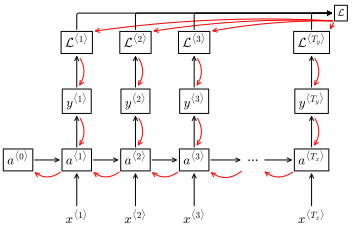

In [5]:
f = Flow(bbox=dict(boxstyle='square'))

for i in range(6):
    lbl = i if i < 5 else 'T_x'

    if i != 4:
        f.node(f'a{i}', label=f'$a^{{\\langle {lbl} \\rangle}}$', fontsize=13, startpoint=f'a{i-1}')
    else:
        f.node(f'a{i}', label='$\\cdots$', startpoint=f'a{i-1}', fontsize=13, bbox=dict(ec='none'))
    if i != 0:
        f.edge(f'a{i}', f'a{i-1}', arrowprops=dict(connectionstyle='arc3,rad=0.4', ec='r'), headport='se', tailport='sw')
        
    if i >0 and i != 4:
        f.node(f'x{i}', label=f'$x^{{\\langle {lbl} \\rangle}}$', startpoint=f'a{i}', travel='s', fontsize=13, 
               edge_kwargs=dict(arrowprops=dict(arrowstyle='->')), bbox=dict(ec='none'))
        if i == 5:
            lbl = 'T_y'
        f.node(f'y{i}', label=f'$y^{{\\langle {lbl} \\rangle}}$', startpoint=f'a{i}', travel='n', fontsize=13)
        f.node(f'l{i}', label=f'$\\mathcal{{L}}^{{\\langle {lbl} \\rangle}}$', travel='n', fontsize=13)
        f.edge(f'l{i}', f'y{i}', arrowprops=dict(connectionstyle='arc3,rad=0.4', ec='r', shrinkA=4, shrinkB=6), headport='n', tailport='s')
        f.edge(f'y{i}', f'a{i}', arrowprops=dict(connectionstyle='arc3,rad=0.4', ec='r', shrinkA=4, shrinkB=6), headport='n', tailport='s')
        
f.node('l', label='$\\mathcal{L}$', startpoint=f'l5', travel='ne', distance=.5, connect=False)

for i in range(1, 6):
    if i != 4:
        f.edge(f'l{i}', 'l', tailport='n', headport='w', arrowprops=dict(connectionstyle='angle,angleA=0,angleB=90,rad=2'))
        f.edge('l', f'l{i}', tailport='sw', headport='ne', arrowprops=dict(connectionstyle='arc3,rad=-0.05', ec='r'))        

<i id="fig:forwardback">Forward propagation (black arrows) and backpropagation (red arrows) in an RNN. Backpropagation propagates the error $\mathcal{L}$ of the single time-steps back through the earlier time-steps. For this reason backpropagation of an RNN is also called backpropagation through time.</i>